# Google Places Sample Data

## Import Packages

In [1]:
!pip install python-dotenv

In [4]:
!pip install folium

  Obtaining dependency information for folium from https://files.pythonhosted.org/packages/ae/6d/18a7546e1748ecdd6ed7cd00d3f183faf1df08bd4f5e5e0eb3e72458b862/folium-0.17.0-py2.py3-none-any.whl.metadata
  Using cached folium-0.17.0-py2.py3-none-any.whl.metadata (3.8 kB)
  Obtaining dependency information for branca>=0.6.0 from https://files.pythonhosted.org/packages/fc/be/720f85abacd654ec86f1431bc7c004eae74417bd9d0e7a2bc43601062627/branca-0.8.0-py3-none-any.whl.metadata
  Using cached branca-0.8.0-py3-none-any.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 4.5 MB/s eta 0:00:00


In [5]:
!pip install geopandas

  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/c4/64/7d344cfcef5efddf9cf32f59af7f855828e9d74b5f862eddf5bfd9f25323/geopandas-1.0.1-py3-none-any.whl.metadata
  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
  Obtaining dependency information for pyogrio>=0.7.2 from https://files.pythonhosted.org/packages/8d/2c/c761e6adeb81bd4029a137b3240e7214a8c9aaf225883356196afd6ef9d8/pyogrio-0.10.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Using cached pyogrio-0.10.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (5.5 kB)
  Using cached pyproj-3.7.0.tar.gz (225 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [1 lines of output]
      proj executable not found. Please set the PROJ_DIR variable. For more information see: https://pyproj4.github.io/pyproj/stable/installat

In [6]:
import requests
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import folium
from dotenv import load_dotenv
from folium.plugins import HeatMap

load_dotenv()

# API Key
API_KEY = os.environ.get('GOOGLE_PLACES_API_KEY')

## Collect Data

In [7]:
def get_places_data(location, radius, place_type, api_key, max_results=20):
    """
    Fetches places data using the Google Places API.
    
    Args:
    - location (str): Latitude and Longitude (e.g., "37.7749,-122.4194")
    - radius (int): Search radius in meters
    - place_type (str): Type of place to search (e.g., 'restaurant', 'tourist_attraction')
    - api_key (str): Your Google Places API key
    - max_results (int): Maximum number of results to return (API returns 20 per request)
    
    Returns:
    - pd.DataFrame: DataFrame containing the places data
    """
    endpoint_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    places = []
    next_page_token = None
    
    while len(places) < max_results:
        # Construct the API request
        params = {
            'location': location,
            'radius': radius,
            'type': place_type,
            'key': api_key
        }

        if next_page_token:
            params['pagetoken'] = next_page_token
        
        # Make the API request
        res = requests.get(endpoint_url, params=params)
        results = res.json()
        
        # Add the results to the list
        places.extend(results['results'])
        
        # Check if there's a next page
        next_page_token = results.get('next_page_token', None)

        # If there is no next page or we've reached the max results, break
        if not next_page_token or len(places) >= max_results:
            break
        
        # Pause to avoid hitting the API rate limit
        time.sleep(2)

    # Create a DataFrame from the results
    data = []
    for place in places:
        place_info = {
            'place_id': place.get('place_id'),
            'name': place.get('name'),
            'address': place.get('vicinity'),
            'rating': place.get('rating'),
            'user_ratings_total': place.get('user_ratings_total'),
            'latitude': place['geometry']['location']['lat'],
            'longitude': place['geometry']['location']['lng'],
            'place_type': place_type
        }
        data.append(place_info)

    return pd.DataFrame(data)

In [8]:
def get_place_details(place_id, api_key):
    """
    Fetch detailed information about a place using the Google Places API.
    
    Args:
    - place_id (str): The unique ID of the place.
    - api_key (str): Your Google Places API key.
    
    Returns:
    - dict: Dictionary containing place details such as reviews and photos.
    """
    endpoint_url = "https://maps.googleapis.com/maps/api/place/details/json"
    params = {
        'place_id': place_id,
        'fields': 'name,rating,reviews,photos',
        'key': api_key
    }
    
    # Make the API request
    response = requests.get(endpoint_url, params=params)
    place_details = response.json().get('result', {})
    
    return place_details

In [9]:
def extract_reviews(place_details):
    """
    Extract reviews from place details.

    Args:
    - place_details (dict): Dictionary containing place details including reviews.
    
    Returns:
    - list: List of reviews for the place.
    """
    reviews = []
    if 'reviews' in place_details:
        for review in place_details['reviews']:
            review_data = {
                'author_name': review['author_name'],
                'rating': review['rating'],
                'text': review['text'],
                'relative_time_description': review['relative_time_description']
            }
            reviews.append(review_data)
    return reviews

In [10]:
def get_photo_urls(place_details, api_key, max_photos=5):
    """
    Fetch photo URLs for a place.
    
    Args:
    - place_details (dict): Dictionary containing place details including photos.
    - api_key (str): Your Google Places API key.
    - max_photos (int): Maximum number of photos to retrieve.
    
    Returns:
    - list: List of photo URLs.
    """
    photo_urls = []
    if 'photos' in place_details:
        for photo in place_details['photos'][:max_photos]:
            # Use the photo reference to construct the photo URL
            photo_reference = photo['photo_reference']
            photo_url = f"https://maps.googleapis.com/maps/api/place/photo?maxwidth=400&photoreference={photo_reference}&key={api_key}"
            photo_urls.append(photo_url)
    return photo_urls

In [11]:
# Run this block sparingly

# Define the location and radius
location = "37.7749,-122.4194"  # San Francisco, CA
radius = 5000  # 5 km radius

# Collect data for different types of places
restaurants_data = get_places_data(location, radius, 'restaurant', API_KEY)
tourist_attractions_data = get_places_data(location, radius, 'tourist_attraction', API_KEY)

In [12]:
# Combine the data
all_places_data = pd.concat([restaurants_data, tourist_attractions_data], ignore_index=True)
all_places_data.head()

,place_id,name,address,rating,user_ratings_total,latitude,longitude,place_type
0,ChIJN2S4EI2AhYAR9J4Qeh1U8Aw,Fairmont San Francisco,"950 Mason Street, San Francisco",4.5,6555,37.792390,-122.410444,restaurant
1,ChIJW52Si_OAhYAR-jAC1-iQh_c,The Stinking Rose,"430 Columbus Avenue, San Francisco",4.2,4149,37.799102,-122.408168,restaurant
2,ChIJF-zbSmSAhYARvOafjdCRszQ,Boulevard,"1 Mission Street, San Francisco",4.6,1547,37.793270,-122.392868,restaurant
3,ChIJNy8VmmGAhYARQF84_9twEc4,Perbacco,"230 California Street, San Francisco",4.4,929,37.793433,-122.399314,restaurant
4,ChIJDVK5qGaAhYAR_goq49KaaEc,One Market Restaurant/Mark 'n Mike's NY Style ...,"1 Market Street, San Francisco",4.3,899,37.794207,-122.394785,restaurant


In [13]:
# Run this block sparingly

# place_id from a previous search
place_id = 'ChIJNy8VmmGAhYARQF84_9twEc4' # TODO: will be changed

# Get place details using the place_id
place_details = get_place_details(place_id, API_KEY)

In [14]:
# Extract reviews
reviews = extract_reviews(place_details)
print("Reviews:")
for review in reviews:
    print(f"Author: {review['author_name']}, Rating: {review['rating']}, Review: {review['text']}")

Reviews:
Author: Laura Peters, Rating: 5, Review: Friends took me to Perbacco for lunch recently. Every dish was impeccable, but I was particularly impressed by the Triangoli ravioli one of my table mates ordered. The flavors were so complex and appealing. The Baba Al Rum dessert was as scrumptious as it looks!
Author: Yu Qin, Rating: 2, Review: Bread came after starters, overcooked octopus, undercooked duck breast, and Americanized pasta. From a person not very picky about what they are eating, I am so disappointed with the quality of foods here and still did not figure out why so many locals recommend me this Italian restaurant.
I love Italian food and go to Italy once a year. These foods are hard to swallow. Sorry, this is just my personal opinion.
Author: Cel B, Rating: 5, Review: Such a great experience! Food was phenomenal and the service was equally as phenomenal. Logan our waiter did a fantastic job serving us. It was my friends birthday and he made sure she had a great experie

In [17]:
# Convert reviews to a DataFrame
reviews_df = pd.DataFrame(reviews)
reviews_df.head()

,author_name,rating,text,relative_time_description
0,Laura Peters,5,Friends took me to Perbacco for lunch recently...,a month ago
1,Yu Qin,2,"Bread came after starters, overcooked octopus,...",5 months ago
2,Cel B,5,Such a great experience! Food was phenomenal a...,a week ago
3,LoMo Phillips,5,Perbacco is an old school Italian spot disguis...,4 months ago
4,Patty Kong,5,I've been to Perbacco several times and have e...,7 months ago


In [ ]:
# Run this block sparingly

# Extract photo URLs
photo_urls = get_photo_urls(place_details, API_KEY)
print("\nPhoto URLs:")
for url in photo_urls:
    print(url)

In [19]:
# Convert photo URLs to a DataFrame
photo_urls_df = pd.DataFrame({'photo_url': photo_urls})
photo_urls_df.head()

,photo_url
0,https://maps.googleapis.com/maps/api/place/pho...
1,https://maps.googleapis.com/maps/api/place/pho...
2,https://maps.googleapis.com/maps/api/place/pho...
3,https://maps.googleapis.com/maps/api/place/pho...
4,https://maps.googleapis.com/maps/api/place/pho...


## Save Data to CSV

In [ ]:
all_places_data.to_csv('travel_places_data.csv', index=False)
reviews_df.to_csv('place_reviews.csv', index=False)
photo_urls_df.to_csv('place_photos.csv', index=False)

## Data Exploration & Preparation

In [20]:
all_places_data.describe()

,rating,user_ratings_total,latitude,longitude
count,40.000000,40.0000,40.000000,40.000000
mean,4.470000,8292.5000,37.788080,-122.412906
std,0.184252,20082.4329,0.013724,0.019994
min,3.800000,156.0000,37.752646,-122.468676
25%,4.400000,1162.0000,37.778396,-122.419577
50%,4.500000,2889.5000,37.791441,-122.407038
75%,4.600000,7561.2500,37.796232,-122.400727
max,4.800000,125648.0000,37.808673,-122.389042


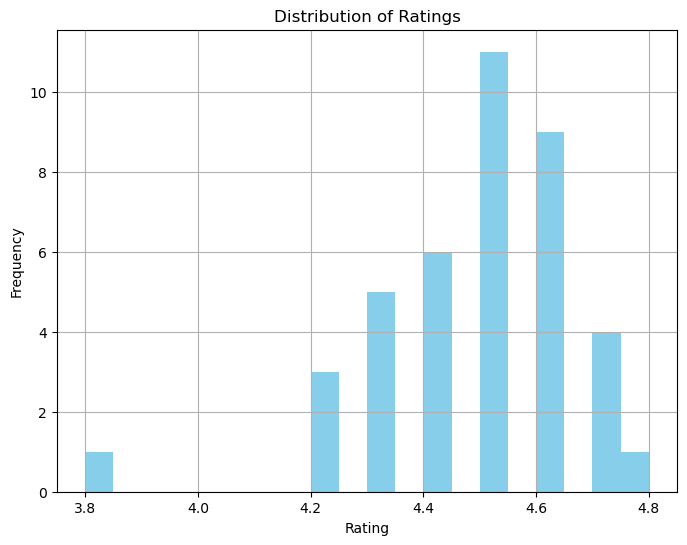

In [21]:
# Plot distribution of ratings
plt.figure(figsize=(8, 6))
all_places_data['rating'].dropna().hist(bins=20, color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [22]:
# Location heatmap to show the density of places

# Filter the data to get the locations (latitude and longitude)
location_data = all_places_data[['latitude', 'longitude']].dropna()

# Get the center of the map (average latitude and longitude)
center_lat = location_data['latitude'].mean()
center_lng = location_data['longitude'].mean()

# Create a Folium map centered on the average coordinates
mymap = folium.Map(location=[center_lat, center_lng], zoom_start=12)

# Create a list of [latitude, longitude] pairs for the heatmap
heatmap_data = [[row['latitude'], row['longitude']] for index, row in location_data.iterrows()]

# Add the HeatMap layer to the map
HeatMap(heatmap_data).add_to(mymap)

# Show the map in the notebook
mymap

In [ ]:
# Save the map as an HTML file
mymap.save('places_heatmap.html')